## play with common envelope events from COSMIC for GW signal

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import glob
import time
import math
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from termcolor import colored
from COSMIClib import *
# parallelization stuff
from joblib import Parallel, delayed
import multiprocessing
import subprocess
import h5py

In [3]:
root = "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/"
folders = glob.glob(root+"*qcrit*/")
for f in folders:
    print(f)

/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.0001/
/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_indipendent_dist/
/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes/
/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_inf/
/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1/
/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes_Z0.002/
/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.1/
/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_2/
/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1000/


In [4]:
def mkPlot(func, RES=5, xlabel="x", ylabel="N", X=0.5,Y=0.5):
    fig = plt.figure(figsize=(15., 15.))
    gs = gridspec.GridSpec(3,3)
    gs.update(wspace=0,hspace=0)# top=1.1)
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax4 = plt.subplot(gs[3])
    ax5 = plt.subplot(gs[4])
    ax6 = plt.subplot(gs[5])
    ax7 = plt.subplot(gs[6])
    ax8 = plt.subplot(gs[7])
    ax9 = plt.subplot(gs[8])
    # set root
    root = "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/"
    # plot
    func(root+"/qcrits_clayes/",ax=ax1, RES=RES)
    ax1.text(X,Y, r"Clayes+14, Moe+17", fontsize=25, color="#808080",va="center", ha="center", transform=ax1.transAxes)

    func(root+"/qcrits_0.0001/",ax=ax2, RES=RES)
    ax2.text(X,Y, r"qcrits=0.0001", fontsize=25, color="#808080",va="center", ha="center", transform=ax2.transAxes)

    func(root+"/qcrits_0.1/",ax=ax3, RES=RES)
    ax3.text(X,Y, r"qcrits=0.1", fontsize=25, color="#808080",va="center", ha="center", transform=ax3.transAxes)

    func(root+"/qcrits_indipendent_dist/",ax=ax4, RES=RES)
    ax4.text(X,Y, r"Clayes+14", fontsize=25, color="#808080",va="center", ha="center", transform=ax4.transAxes)

    func(root+"/qcrits_1/",ax=ax5, RES=RES)
    ax5.text(X,Y, r"qcrits=1", fontsize=25, color="#808080",va="center", ha="center", transform=ax5.transAxes)

    func(root+"/qcrits_2/",ax=ax6, RES=RES)
    ax6.text(X,Y, r"qcrits=2", fontsize=25, color="#808080",va="center", ha="center", transform=ax6.transAxes)

    func(root+"/qcrits_clayes_Z0.002/",ax=ax7, RES=RES)                  
    ax7.text(X,Y, r"Clayes+14, $Z=0.002$", fontsize=25, color="#808080",va="center", ha="center", transform=ax7.transAxes)

    func(root+"/qcrits_1000/",ax=ax8, RES=RES)
    ax8.text(X,Y, r"qcrits=1000", fontsize=25, color="#808080",va="center", ha="center", transform=ax8.transAxes)

    func(root+"/qcrits_inf/",ax=ax9, RES=RES)
    ax9.text(X,Y, r"qcrits=$\infty$", fontsize=25, color="#808080",va="center", ha="center", transform=ax9.transAxes)

        
    # beautification
    axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8, ax9]
    for ax in axes:
        # ax.text(0.5,0.5,"%d"%(axes.index(ax)+1))
        ax.tick_params(axis='both', which='major', width=2, top="on", right="on", length=12, pad=10, labelsize=30, direction='in')
        ax.tick_params(axis='both', which='minor', width=2, top="on", right="on", length=6, pad=10, direction='in')
    
    ax1.set_xticklabels([])
    ax1.set_xlabel("")
    ax1.set_ylabel(ylabel, fontsize=30)

    ax2.set_xticklabels([])
    ax2.set_xlabel("")
    
    ax3.set_xticklabels([])
    ax3.set_xlabel("")
    
    ax4.set_xticklabels([])
    ax4.set_ylabel(ylabel, fontsize=30)
    ax4.set_xlabel("")
    
    ax5.set_xticklabels([])
    ax5.set_xlabel("")
    
    ax6.set_xticklabels([])
    ax6.set_xlabel("")
    
    ax2.set_yticklabels([])
    ax2.set_ylabel("")

    ax3.set_yticklabels([])
    ax3.set_ylabel("")

    ax5.set_yticklabels([])
    ax5.set_ylabel("")

    ax6.set_yticklabels([])
    ax6.set_ylabel("")

    ax7.set_xlabel(xlabel, fontsize=30)
    ax7.set_ylabel(ylabel, fontsize=30)
    
    ax8.set_yticklabels([])
    ax8.set_ylabel("")
    ax8.set_xlabel(xlabel, fontsize=30)
    
    ax9.set_yticklabels([])
    ax9.set_ylabel("")
    ax9.set_xlabel(xlabel, fontsize=30)
    
    #end
#test    
# mkPlot(plot_q_Pinit)

/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_clayes/ all double core CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_0.0001/ all double core CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_0.1/ all double core CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_indipendent_dist/ all double core CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_1/ all double core CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_2/ all double core CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_clayes_Z0.002/ all double core CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_1000/ all double core CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_inf/ all double core CE


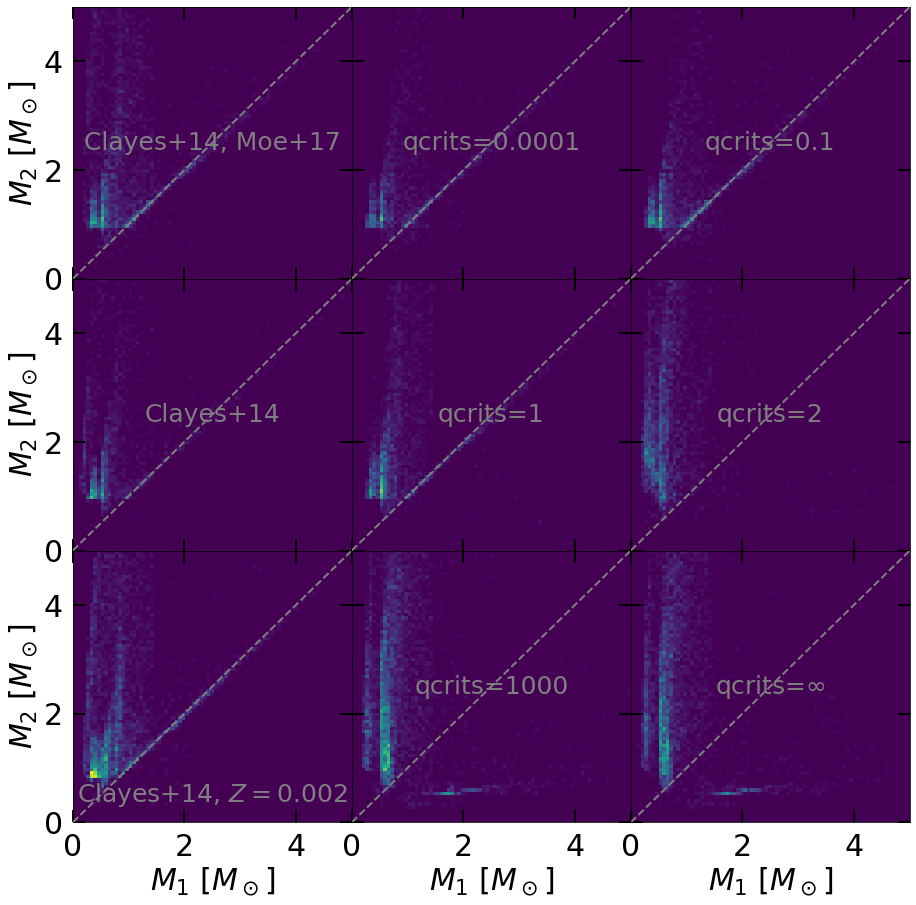

In [17]:
def M1_M2_pre_CE(folder, ax, RES=5):
    
    h5frame = glob.glob(folder+"*.h5")[0]
    bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes

    iCEdoublecore = (bpp.evol_type == 7) & ((bpp.kstar_1>1) & (bpp.kstar_2>1)) # CE initiation and both stars are post MS, so both have a core
    print(folder, "all double core CE")

    M1 = bpp.loc[iCEdoublecore].mass_1
    M2 = bpp.loc[iCEdoublecore].mass_2

    ax.set_xlim(0,5)
    ax.set_ylim(0,5)
    ax.plot(np.linspace(0,20,2),np.linspace(0,20,2),ls="--",lw=2,c="#808080",zorder=10)

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    X = np.linspace(xmin, xmax, RES)
    Y = np.linspace(ymin, ymax, RES)
    mat = np.zeros((len(X),len(Y)))

    for i in range(0,len(X)-1,1):
        # print("x", i, X[i])
        Nx =((M1[:] >= X[i]) & (M1[:] < X[i+1]))
        for j in range(0,len(Y)-1,1):
            # print("y", j, Y[j])
            Ny = ((M2[:] >= Y[j]) & (M2[:] < Y[j+1]))
            # print(Nx.sum(),Ny.sum())
            mat[j,i] = np.sum((Nx & Ny))

    p = ax.pcolor(X,Y,mat, vmin=0, vmax=50)

mkPlot(M1_M2_pre_CE, RES=80, xlabel="$M_1 \ [M_\odot]$", ylabel="$M_2 \ [M_\odot]$", X=0.5,Y=0.5)
    

/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_clayes/ all CE


/mnt/home/mrenzo/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_0.0001/ all CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_0.1/ all CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_indipendent_dist/ all CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_1/ all CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_2/ all CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_clayes_Z0.002/ all CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_1000/ all CE


/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC//qcrits_inf/ all CE


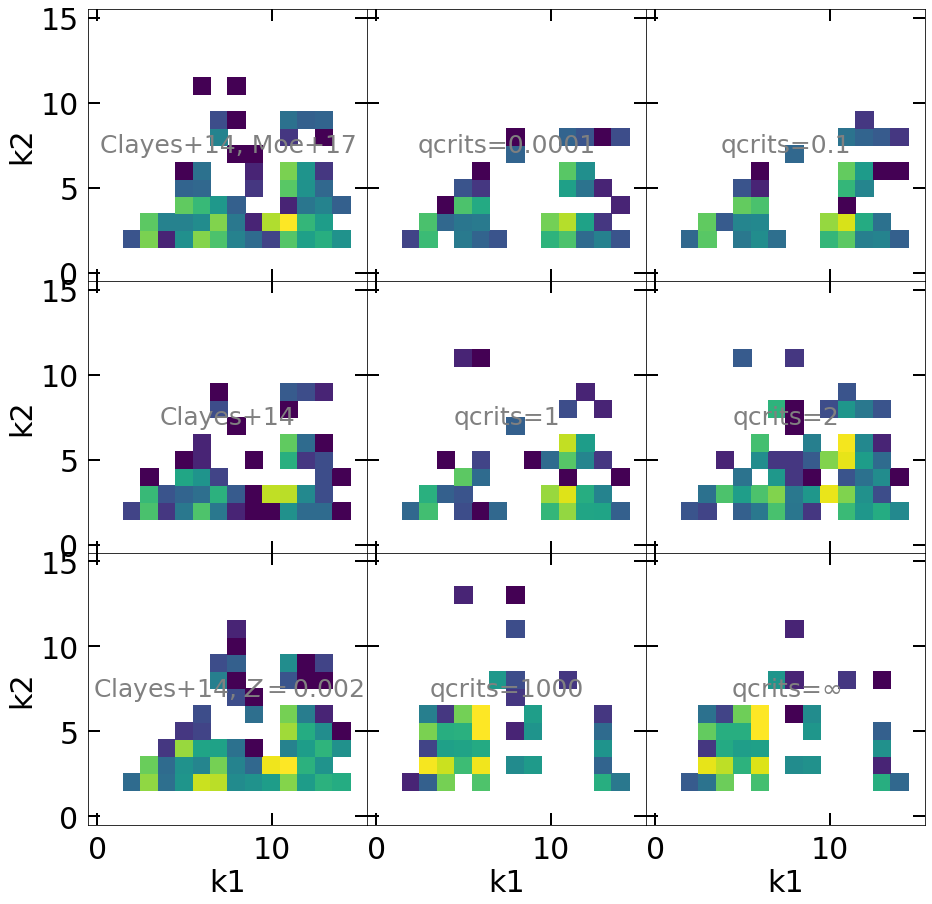

In [32]:
def kstar1_kstar2_onsetCE(folder, ax, RES=17):

    h5frame = glob.glob(folder+"*.h5")[0]
    bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes

    iCE = (bpp.evol_type == 7) & ((bpp.kstar_1>1) & (bpp.kstar_2>1)) # CE initiation and both stars are post MS, so both have a core
    print(folder, "all CE")

    k1 = bpp.loc[iCE].kstar_1
    k2 = bpp.loc[iCE].kstar_2

    ax.set_xlim(-0.5,15.5)
    ax.set_ylim(-0.5,15.5)
    ## hardcode resolution
    RES=17

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    X = np.linspace(xmin, xmax, RES)
    Y = np.linspace(ymin, ymax, RES)
    mat = np.zeros((len(X),len(Y)))

    for i in range(0,len(X)-1,1):
        # print("x", i, X[i])
        Nx =((k1[:] >= X[i]) & (k1[:] < X[i+1]))
        for j in range(0,len(Y)-1,1):
            # print("y", j, Y[j])
            Ny = ((k2[:] >= Y[j]) & (k2[:] < Y[j+1]))
            # print(Nx.sum(),Ny.sum())
            mat[j,i] = np.sum((Nx & Ny))

    p = ax.pcolor(X,Y,np.log10(mat), vmin=0, vmax=3)
    
mkPlot(kstar1_kstar2_onsetCE,RES=15, xlabel="k1", ylabel="k2")    

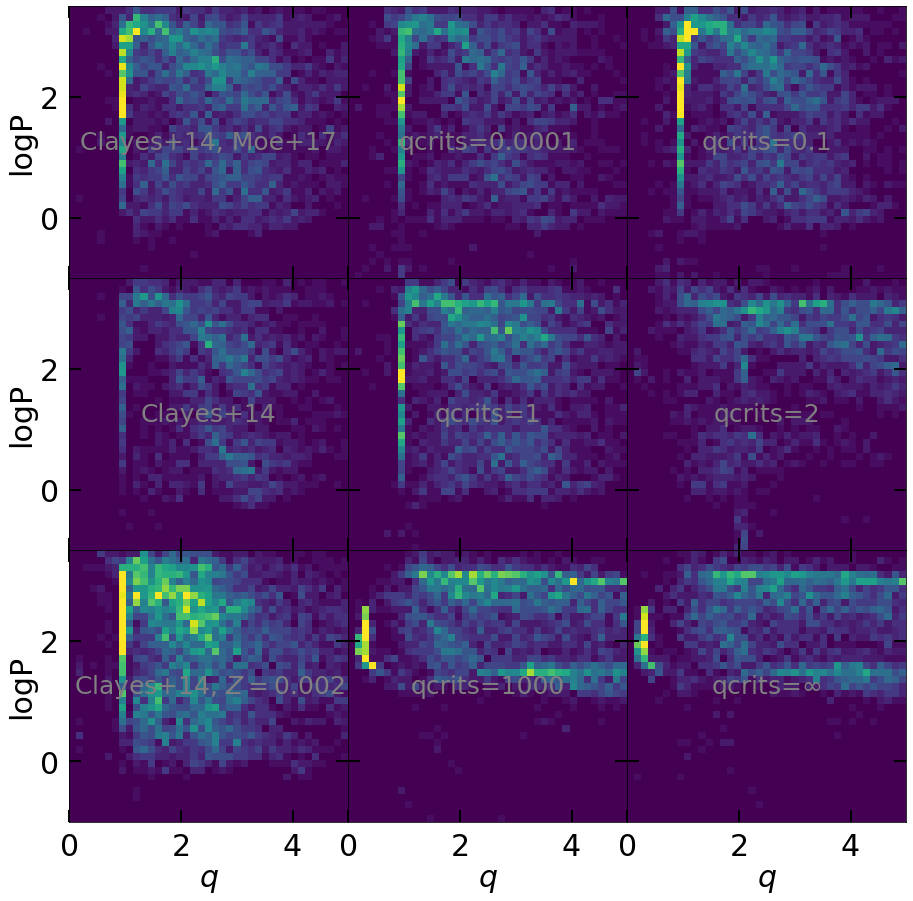

In [10]:
def plot_q_Pinit(folder,ax, RES=5):

    h5frame = glob.glob(folder+"*.h5")[0]
    bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes

    iCEdoublecore = (bpp.evol_type == 7) & ((bpp.kstar_1>1) & (bpp.kstar_2>1)) # CE initiation and both stars are post MS, so both have a core

    M1 = bpp.loc[iCEdoublecore].mass_1
    M2 = bpp.loc[iCEdoublecore].mass_2
    logP =  np.log10(bpp.loc[bpp.evol_type==7].porb)
    q = M2/M1

    ax.set_xlim(0,5)
    ax.set_ylim(-1,3.5)

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    X = np.linspace(xmin, xmax, RES)
    Y = np.linspace(ymin, ymax, RES)
    mat = np.zeros((len(X),len(Y)))

    for i in range(0,len(X)-1,1):
        # print("x", i, X[i])
        Nx =((q[:] >= X[i]) & (q[:] < X[i+1]))
        for j in range(0,len(Y)-1,1):
            # print("y", j, Y[j])
            Ny = ((logP[:] >= Y[j]) & (logP[:] < Y[j+1]))
            # print(Nx.sum(),Ny.sum())
            mat[j,i] = np.sum((Nx & Ny))

    p = ax.pcolor(X,Y,mat, vmin=0, vmax=30)
    ax.set_xlabel(r"$q_\mathrm{pre-CE}=M2/M1$", fontsize=30)
    ax.set_ylabel(r"$\log_{10}(P/\mathrm{days})$",fontsize=30)

mkPlot(plot_q_Pinit,RES=40, xlabel="$q$", ylabel="logP")
    

In [4]:
conv = pd.read_hdf(h5frame, key='conv')
bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes
# bcm =  pd.read_hdf(h5frame, key='bcm') # specific times (with the default init this is at the end of the evolution)
initC = pd.read_hdf(h5frame, key="initCond") # initial conditions
total_mass = pd.read_hdf(h5frame, key='mass_stars')

In [20]:
print(bpp.columns)

Index(['tphys', 'mass_1', 'mass_2', 'kstar_1', 'kstar_2', 'sep', 'porb', 'ecc',
       'RROL_1', 'RROL_2', 'evol_type', 'Vsys_1', 'Vsys_2', 'SNkick',
       'SNtheta', 'aj_1', 'aj_2', 'tms_1', 'tms_2', 'massc_1', 'massc_2',
       'rad_1', 'rad_2', 'bin_num'],
      dtype='object')


In [ ]:
print(bpp.columns)
# print(bpp.mass_1[iCEinit])
# print(bpp.mass_2[iCEinit])
# print(bpp.bin_num[iCEinit])

# CEbin_num = bpp.loc[bpp.evol_type==7].bin_num
RLOFbin_num = bpp.loc[bpp.evol_type==3].bin_num
for bin_num in CEbin_num:
    # print(bpp.loc[bpp.bin_num == bin_num][["mass_1","mass_2","evol_type", "kstar_1","kstar_2","porb", "bin_num"]])
    

In [15]:
def getCErates(folder, SFR=3.5):
    # SFR is the assumed star formation rate in Msun/yr
    # folder contains the h5 frame output from cosmic-pop
    
    h5frame = glob.glob(folder+"*.h5")[0]
    bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes
    total_mass = pd.read_hdf(h5frame, key='mass_stars')
    # total mass of the simulation
    Mtot = max(np.array(total_mass))[0]
    
    ## all CE events
    ## convert to astrophysical rate
    ## following https://cosmic-popsynth.github.io/docs/stable/fixedpop/index.html
    
    # get all CE event initiations
    iCEinit = bpp.evol_type == 7 # evol_type == 7 means beginning of CE event
        
    Nastro_CE = np.sum(iCEinit) # sum of all the CE events that are occurring
    Nastro_CE *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CE *= SFR # [1/yr]

    print("number of CE events of any type initiated per year:",Nastro_CE)
    print("so every ~ %.0f"%float(1.0/Nastro_CE),"years a CE event starts in the Galaxy")
    
    print("=============================================================================")
    # =============================================================================
    
    ## only double core CE events
    # now lets get only the ones with a double core CE
    iCEdoublecore = (bpp.evol_type == 7) & ((bpp.kstar_1>1) & (bpp.kstar_2>1)) # CE initiation and both stars are post MS, so both have a core
    # print(np.sum(iCEdoublecore))
    
    Nastro_CEdc = np.sum(iCEdoublecore) # sum of all the CE events that are occurring
    Nastro_CEdc *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CEdc *= SFR # [1/yr]
    
    print("number of double core (both post-MS) CE initiated per year:",Nastro_CEdc)
    print("so every ~ %.0f"%float(1.0/Nastro_CEdc),"years a double core CE event starts in the Galaxy")
    print("=============================================================================")
    # =============================================================================
    ## only double core CE events
    # now lets get only the ones with a double core CE
    iCEdoublecoreMS = (bpp.evol_type == 7) & ((bpp.kstar_1>1) & (bpp.kstar_2<=1)) # CE initiation and both stars are post MS, so both have a core
    # print(np.sum(iCEdoublecore))
    
    Nastro_CEdcMS = np.sum(iCEdoublecoreMS) # sum of all the CE events that are occurring
    Nastro_CEdcMS *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CEdcMS *= SFR # [1/yr]
    
    print("number of kstar_1 and kstar_2 <=1 CE initiated per year:",Nastro_CEdcMS)
    print("so every ~ %.0f"%float(1.0/Nastro_CEdcMS),"years a double core CE event starts in the Galaxy")
    print("=============================================================================")

    # ## only CE with a compact object
    # iCEcompobj = (bpp.evol_type == 7) & (isNSBHWD(bpp.kstar_1) | isNSBHWD(bpp.kstar_2))
    

    # Nastro_CEcompobj = np.sum(iCEcompobj) # sum of all the CE events that are occurring
    # Nastro_CEcompobj *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    # Nastro_CEcompobj *= SFR # [1/yr]
    
    # print("number of CE with NS/BH initiated per year:",Nastro_CEcompobj)
    # print("so every ~ %.0f"%float(1.0/Nastro_CEcompobj),"years a double core CE event starts in the Galaxy")
    # print("")
    # print("=============================================================================")
    # print("")
    # =============================================================================



In [16]:
## run this cell to get CE rates for different types
root = "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC"
folders = sorted(glob.glob(root+'/*/'))
for f in folders:
    print("=============================================================================")
    print("*assuming SFR=3.5Msun/yr*", f.split('/')[-2])
    print("=============================================================================")
    getCErates(f)
    print("=============================================================================")
    print("=============================================================================")
    print("=============================================================================")

*assuming SFR=3.5Msun/yr* qcrits_0.0001


number of CE events of any type initiated per year: 0.18821843179369752
so every ~ 5 years a CE event starts in the Galaxy
number of double core (both post-MS) CE initiated per year: 0.033617546199951547
so every ~ 30 years a double core CE event starts in the Galaxy
number of kstar_1 and kstar_2 <=1 CE initiated per year: 0.15460088559374596
so every ~ 6 years a double core CE event starts in the Galaxy
*assuming SFR=3.5Msun/yr* qcrits_0.1


number of CE events of any type initiated per year: 0.18573948764655396
so every ~ 5 years a CE event starts in the Galaxy
number of double core (both post-MS) CE initiated per year: 0.03386281522474894
so every ~ 30 years a double core CE event starts in the Galaxy
number of kstar_1 and kstar_2 <=1 CE initiated per year: 0.151876672421805
so every ~ 7 years a double core CE event starts in the Galaxy
*assuming SFR=3.5Msun/yr* qcrits_1


number of CE events of any type initiated per year: 0.1766834550692073
so every ~ 6 years a CE event starts in the Galaxy
number of double core (both post-MS) CE initiated per year: 0.03818324337411346
so every ~ 26 years a double core CE event starts in the Galaxy
number of kstar_1 and kstar_2 <=1 CE initiated per year: 0.13850021169509383
so every ~ 7 years a double core CE event starts in the Galaxy
*assuming SFR=3.5Msun/yr* qcrits_1000


number of CE events of any type initiated per year: 0.09178380701767239
so every ~ 11 years a CE event starts in the Galaxy
number of double core (both post-MS) CE initiated per year: 0.08151173299794737
so every ~ 12 years a double core CE event starts in the Galaxy
number of kstar_1 and kstar_2 <=1 CE initiated per year: 0.010272074019725014
so every ~ 97 years a double core CE event starts in the Galaxy
*assuming SFR=3.5Msun/yr* qcrits_2


number of CE events of any type initiated per year: 0.151101735160086
so every ~ 7 years a CE event starts in the Galaxy
number of double core (both post-MS) CE initiated per year: 0.07200336938938688
so every ~ 14 years a double core CE event starts in the Galaxy
number of kstar_1 and kstar_2 <=1 CE initiated per year: 0.07909836577069909
so every ~ 13 years a double core CE event starts in the Galaxy
*assuming SFR=3.5Msun/yr* qcrits_clayes


number of CE events of any type initiated per year: 0.1774535049616231
so every ~ 6 years a CE event starts in the Galaxy
number of double core (both post-MS) CE initiated per year: 0.05540397485777042
so every ~ 18 years a double core CE event starts in the Galaxy
number of kstar_1 and kstar_2 <=1 CE initiated per year: 0.12204953010385267
so every ~ 8 years a double core CE event starts in the Galaxy
*assuming SFR=3.5Msun/yr* qcrits_clayes_Z0.002


number of CE events of any type initiated per year: 0.2023131256161813
so every ~ 5 years a CE event starts in the Galaxy
number of double core (both post-MS) CE initiated per year: 0.06831950388065752
so every ~ 15 years a double core CE event starts in the Galaxy
number of kstar_1 and kstar_2 <=1 CE initiated per year: 0.13399362173552382
so every ~ 7 years a double core CE event starts in the Galaxy
*assuming SFR=3.5Msun/yr* qcrits_indipendent_dist


number of CE events of any type initiated per year: 0.16299913432905375
so every ~ 6 years a CE event starts in the Galaxy
number of double core (both post-MS) CE initiated per year: 0.03501728081914825
so every ~ 29 years a double core CE event starts in the Galaxy
number of kstar_1 and kstar_2 <=1 CE initiated per year: 0.1279818535099055
so every ~ 8 years a double core CE event starts in the Galaxy
*assuming SFR=3.5Msun/yr* qcrits_inf


number of CE events of any type initiated per year: 0.09096252779337732
so every ~ 11 years a CE event starts in the Galaxy
number of double core (both post-MS) CE initiated per year: 0.08150429319611986
so every ~ 12 years a double core CE event starts in the Galaxy
number of kstar_1 and kstar_2 <=1 CE initiated per year: 0.009458234597257462
so every ~ 106 years a double core CE event starts in the Galaxy
